In [3]:
import astropy
import sep
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams

rcParams['figure.figsize'] = [10., 8.]

In [4]:
fname = 'hlsp_hudf12_hst_wfc3ir_udfmain_f105w_v1.0_drz.fits'
hdu_list = fits.open(fname)
hdu_list.info()
print(hdu_list)

Filename: hlsp_hudf12_hst_wfc3ir_udfmain_f105w_v1.0_drz.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     359   (3600, 3600)   float32   


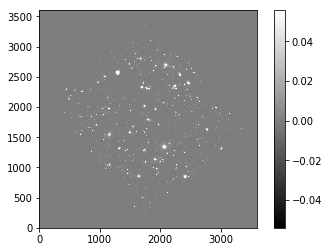

In [5]:
image_data = astropy.io.fits.getdata(fname)    #obtains the actual data from the fits file

#show image
m, s = np.mean(image_data), np.std(image_data) 
plt.imshow(image_data, interpolation = 'nearest', cmap = 'gray', vmin = m-s, vmax = m+s,  origin = 'lower')
plt.colorbar()

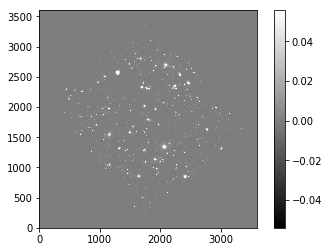

In [6]:
image_data = hdu_list[0].data
m, s = np.mean(image_data), np.std(image_data)
plt.imshow(image_data, interpolation = 'nearest', cmap='gray', vmin = m-s, vmax = m+s, origin='lower')
plt.colorbar()

In [7]:
image_data = image_data.byteswap().newbyteorder()
bkg = sep.Background(image_data, bw=64, bh=64, fw=3, fh=3)
print(bkg.globalback)
print(bkg.globalrms)

0.0
0.0005398219218477607


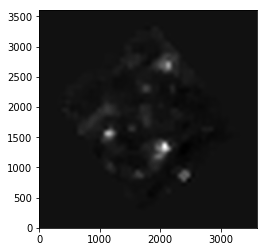

In [8]:
bkg_image = bkg.back() #evaluates background as a 2d array, like the original image
plt.imshow(bkg_image, interpolation='nearest', cmap='gray', origin='lower')

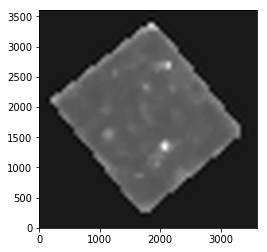

In [9]:
#background noise as a 2d array
bkg_rms = bkg.rms()
plt.imshow(bkg_rms, interpolation='nearest', cmap='gray', origin='lower')

In [10]:
#subtract the background
image_data_sub = image_data-bkg

In [11]:
thresh = 50
objects = sep.extract(image_data_sub, thresh, err=bkg.globalrms*1.5)
#what should thresh be, depends on image?
print('Number of objects detected: ', len(objects))

Number of objects detected:  337


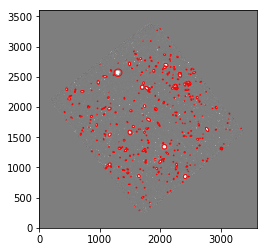

In [12]:
from matplotlib.patches import Ellipse

#plot background-subtracted image
fig, ax = plt.subplots()
m, s = np.mean(image_data_sub), np.std(image_data_sub)
im = ax.imshow(image_data_sub, interpolation='nearest', cmap='gray', vmin=m-s, vmax=m+s, origin='lower')

#plot an ellipse for each object
for i in range(len(objects)):
    e = Ellipse(xy=(objects['x'][i], objects['y'][i]), width=10*objects['a'][i], height=10*objects['b'][i],
                angle=objects['theta'][i] * 180. / np.pi)
    e.set_facecolor('none')
    e.set_edgecolor('red')
    ax.add_artist(e)

### Kehan Zou: Convert to AB magnitudes

In [13]:
flux, fluxerr, flag = sep.sum_circle(image_data_sub, objects['x'], objects['y'],
                                     3.0, err=bkg.globalrms, gain=1.0)

In [14]:
for i in range(len(objects)):
    print("object {:d}: flux = {:f} +/- {:f}".format(i, flux[i], fluxerr[i]))

object 0: flux = 1.149151 +/- 1.071988
object 1: flux = 1.124048 +/- 1.060215
object 2: flux = 0.836182 +/- 0.914434
object 3: flux = 1.253069 +/- 1.119409
object 4: flux = 0.966279 +/- 0.982999
object 5: flux = 3.191317 +/- 1.786428
object 6: flux = 1.042167 +/- 1.020870
object 7: flux = 1.423228 +/- 1.192994
object 8: flux = 2.253843 +/- 1.501283
object 9: flux = 1.203226 +/- 1.096920
object 10: flux = 8.215208 +/- 2.866220
object 11: flux = 1.310683 +/- 1.144854
object 12: flux = 1.472863 +/- 1.213619
object 13: flux = 1.027670 +/- 1.013745
object 14: flux = 1.926768 +/- 1.388084
object 15: flux = 1.485419 +/- 1.218781
object 16: flux = 1.044316 +/- 1.021922
object 17: flux = 1.413579 +/- 1.188944
object 18: flux = 2.076754 +/- 1.441097
object 19: flux = 2.317802 +/- 1.522436
object 20: flux = 3.382481 +/- 1.839154
object 21: flux = 1.118999 +/- 1.057832
object 22: flux = 1.315258 +/- 1.146850
object 23: flux = 3.314068 +/- 1.820460
object 24: flux = 1.107887 +/- 1.052566
object 25:

In [19]:
AB_mag = [0] * len(objects)
for nmbr in range(len(objects)):
    
    AB_mag[nmbr]= -2.5*np.math.log10(flux[nmbr]/4)
    print(AB_mag[nmbr])

1.3542073633343619
1.3781878650836337
1.6993982792704
1.2602123993116399
1.5423938826986672
0.24522510037781542
1.4603065753711297
1.1219641267274636
0.6228406287209776
1.3042818993062952
-0.7813963825264435
1.211405514216149
1.0847439607560245
1.475515548219708
0.79307625494067
1.0755277491568171
1.4580698840847053
1.1293498609368096
0.7116874956682471
0.592459263877984
0.18206165215853096
1.3830752531226418
1.2076229414607351
0.20424645611417047
1.3939114025073622
-3.0403428841317486
-3.1445144525599766
1.1205518435234691
1.171685513901729
1.1655249236189447
0.9914741656551819
0.14522654556860892
0.30926553094994247
0.06433479193204521
0.9574248403149499
1.4137365480997324
1.4661219260508696
0.634187983382285
0.13688889932111198
1.4353593691965858
0.727535054910333
0.44001823123352385
0.3120995061859415
0.4476676849381249
1.3379625706392786
-0.363568472960754
-0.5510722563121166
1.149516900231811
-0.1895743188792802
0.6739161159368939
0.5738550690902157
0.24998627748493457
0.83955364

(-6.0, 6.0)

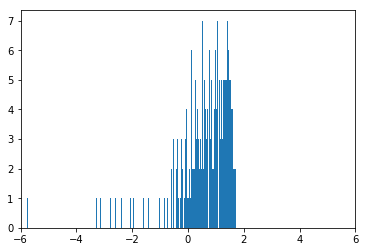

In [22]:
histogram = plt.hist(AB_mag, bins=len(AB_mag))
plt.xlim(-6.,6.)